In [2]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload
from analysis import ModelEvaluator

## Load data and evaluate model

In [4]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

# Add an arbitrary data split for testing functions
df["random"] = np.random.uniform(0, 1, len(df.index))
df["split"] = np.where(df["random"]  > 0.70, "V", "T")

In [7]:
df["split"].value_counts(dropna=False, normalize=True)

split
T    0.698923
V    0.301077
Name: proportion, dtype: float64

In [8]:
df.groupby("split")["target"].mean()

split
T    0.116111
V    0.119013
Name: target, dtype: float64

### Add GLM and GBM predictions for testing functions

In [9]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [10]:
# Split data; define features and target
X = df.drop(columns=["y", "split", "target"])
X_train = df.query("split == 'T'").drop(columns=["y", "split", "target"])
X_test = df.query("split == 'V'").drop(columns=["y", "split", "target"])
y_train = df.query("split == 'T'")["target"]
y_test = df.query("split == 'V'")["target"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# GLM model
glm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear'))
])
glm_pipeline.fit(X_train, y_train)
df["pred_glm"] = glm_pipeline.predict_proba(X)[:, 1]

# XGBoost model
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
df["pred_xgb"] = xgb_pipeline.predict_proba(X)[:, 1]


In [11]:
df[["pred_glm", "pred_xgb", "target"]].describe()

,pred_glm,pred_xgb,target
count,45211.000000,45211.000000,45211.000000
mean,0.116469,0.123572,0.116985
std,0.183998,0.239797,0.321406
min,0.000033,0.000002,0.000000
25%,0.021003,0.001131,0.000000
50%,0.045486,0.008802,0.000000
75%,0.110179,0.091841,0.000000
max,1.000000,0.998170,1.000000


## plot_target_vs_predictors function

In [12]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:196: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_temp.groupby("bin")[target].mean().reset_index()
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of tick

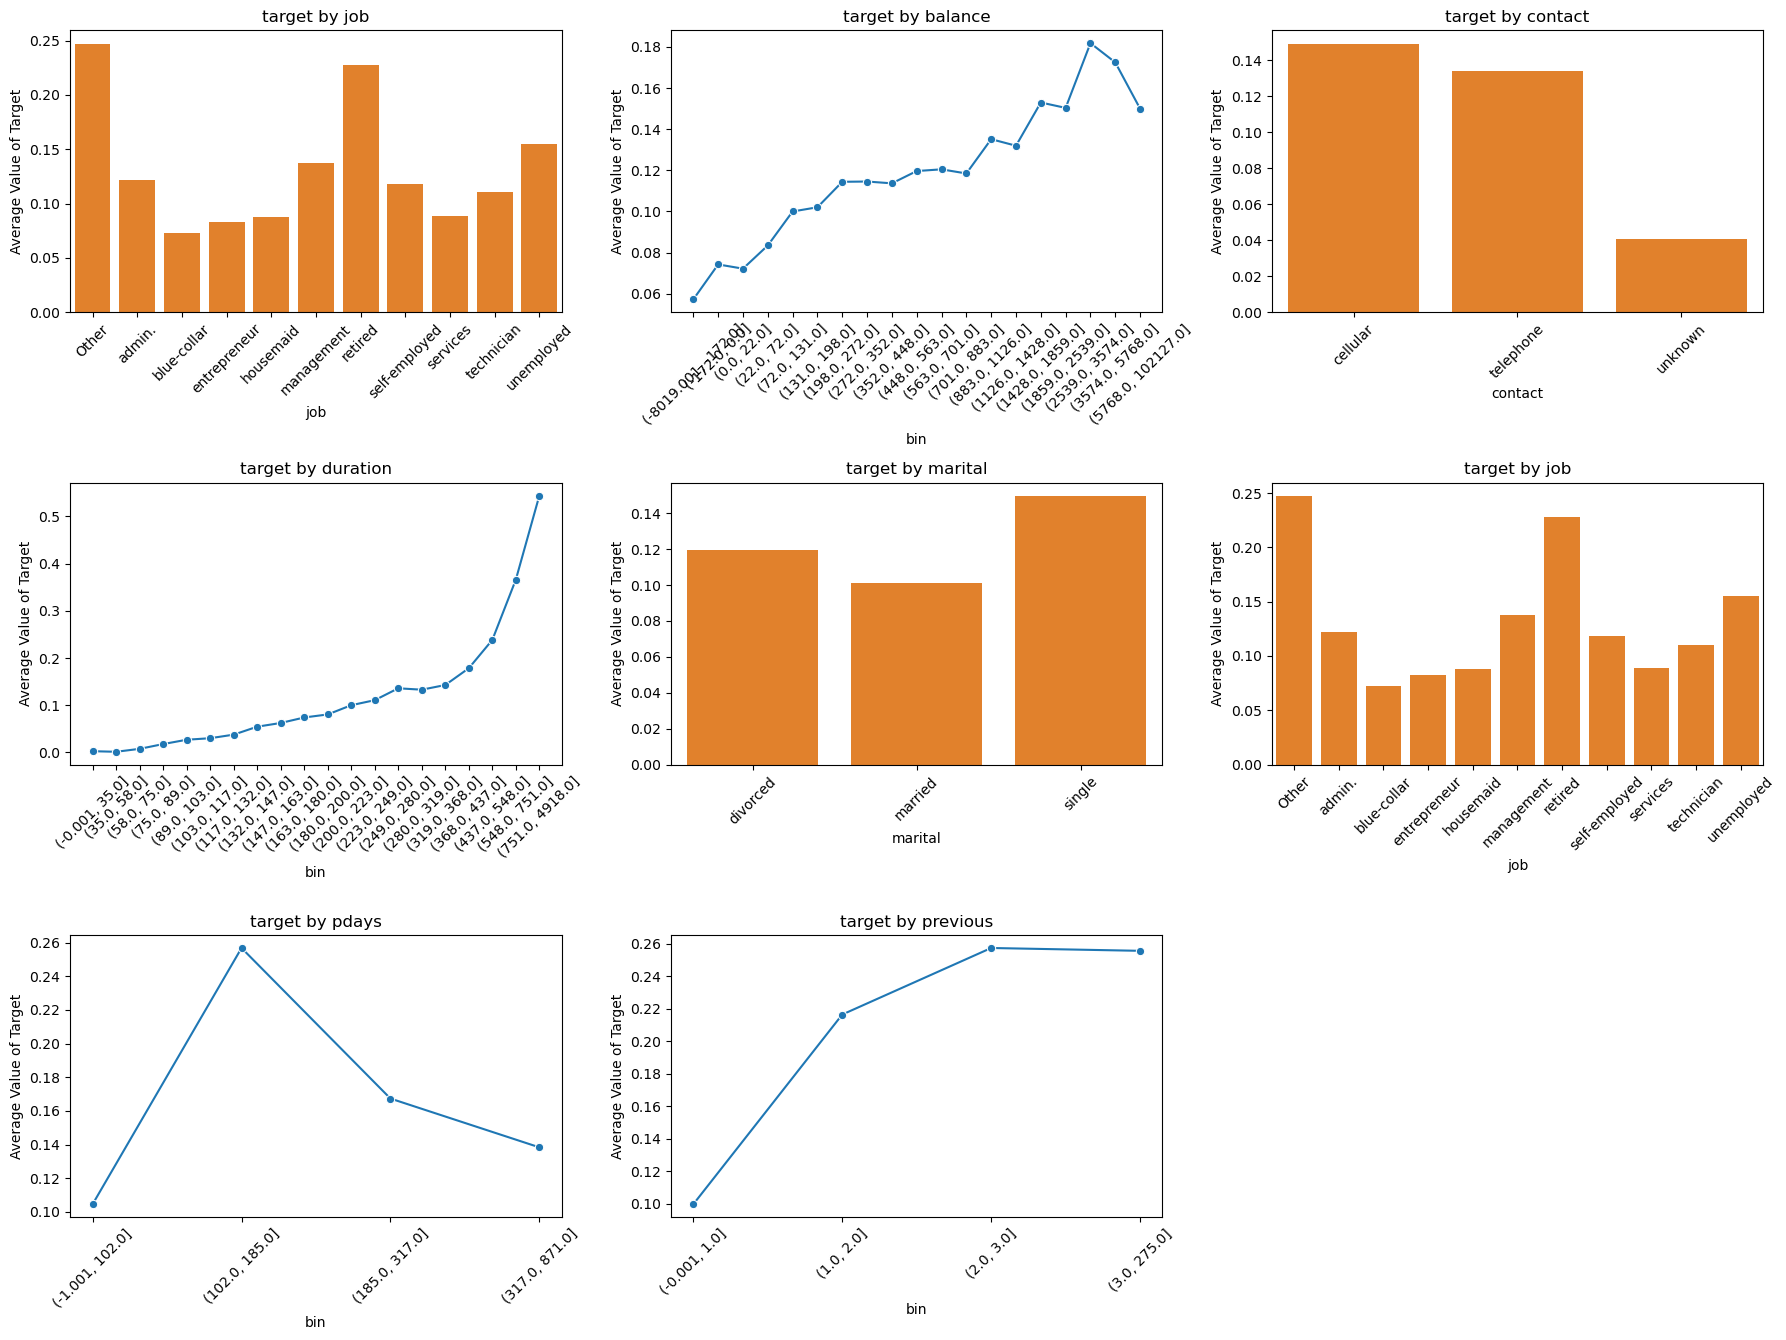

In [16]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors)

In [19]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors, group_col="loan")

TypeError: plot_target_vs_predictors() got an unexpected keyword argument 'group_col'

## Error plots

In [22]:
from analysis.plots import plot_error_by_group
plot_error_by_group(
    df.query("split == 'V'"), 
    "target", 
    "pred_glm", 
    predictors, 
    bins=10
    )

AttributeError: 'DataFrame' object has no attribute 'unique'

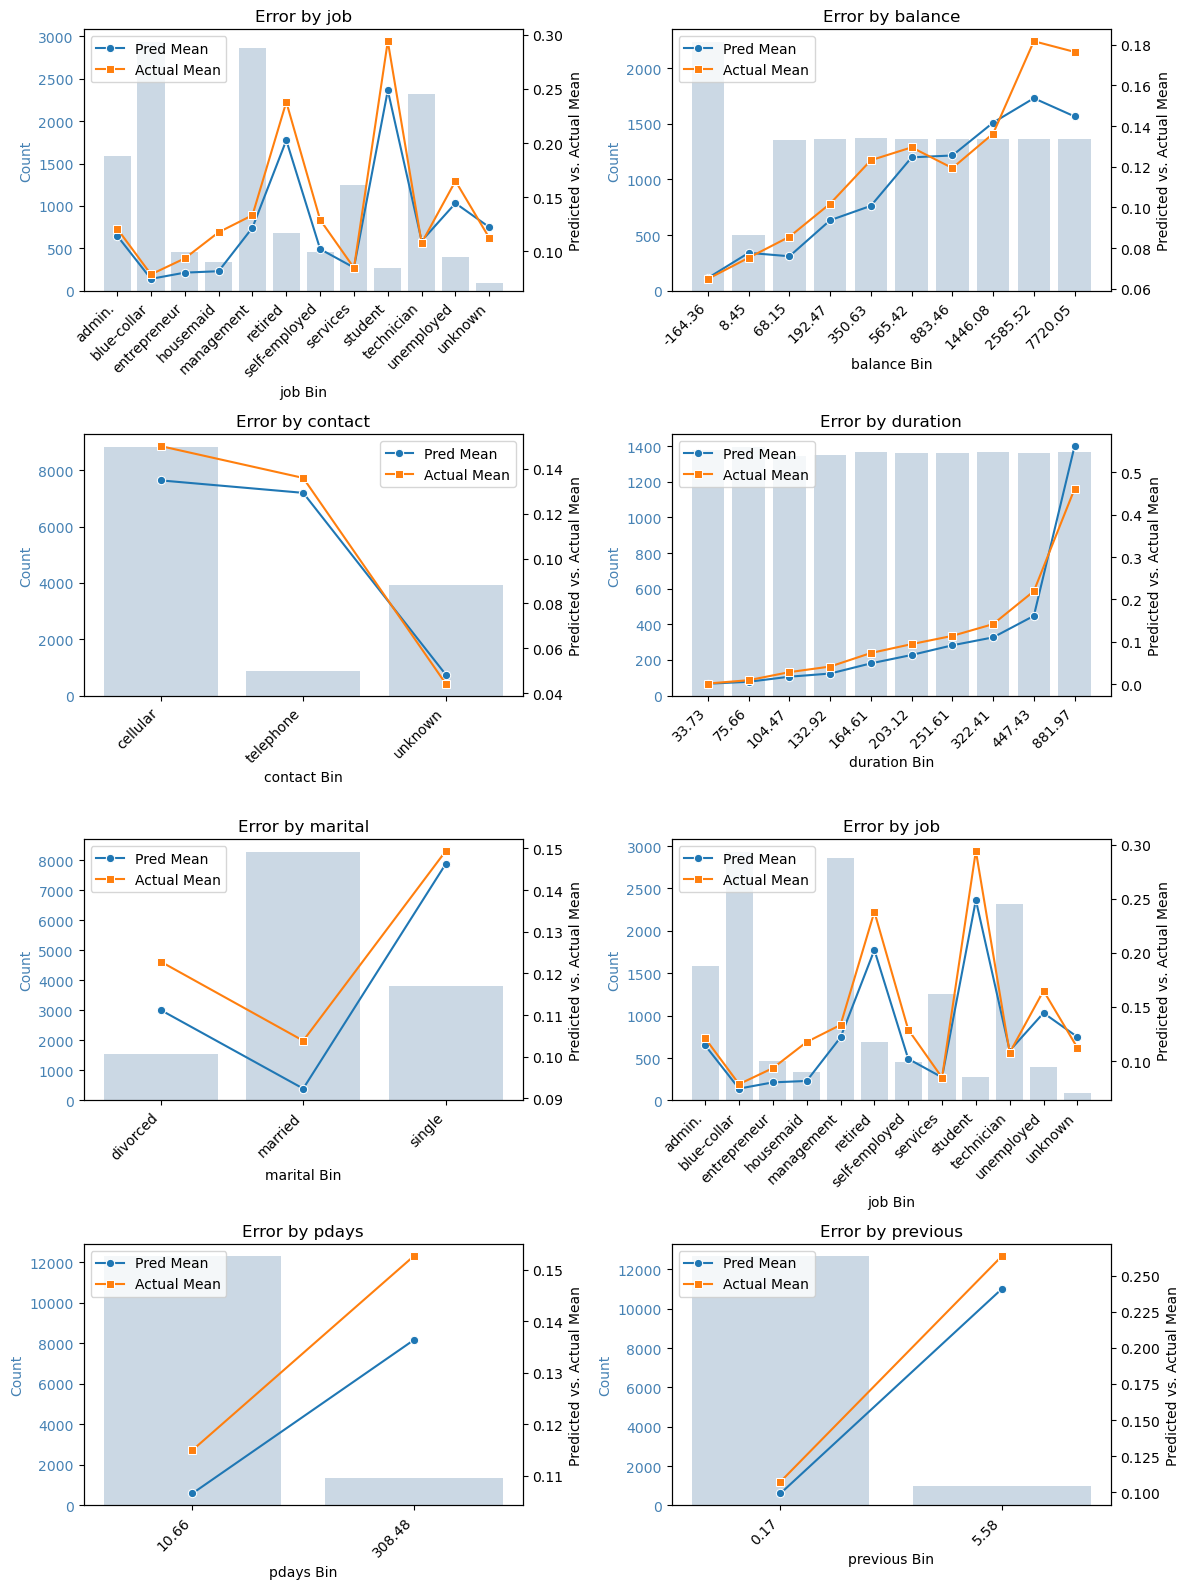

In [45]:
f.plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_xgb", 
    predictors, 
    bins=10
    )

## Explore creation of tabulation function and object

In [36]:
tabs = generate_and_save_tabulations(
    df=df,
    prediction_col="pred_glm",
    truth_col="target",
    group_vars=predictors,
    weights_col="weights",
    split_col="split",
    n_bins=10,
)


Tabulation report written to: tabulations.html
